Data Acquisition and Preprocessing (Category I)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
import re
import os
import requests
from collections import Counter
import pickle

url_sherlock = "https://www.gutenberg.org/files/1661/1661-0.txt"
r = requests.get(url_sherlock)
with open('sherlock_holmes.txt', 'wb') as f:
    f.write(r.content)

print(f"Downloaded Sherlock Holmes corpus ({len(r.content)} bytes).")

Downloaded Sherlock Holmes corpus (607504 bytes).


Clean and preprocess the text

In [2]:
def preprocess_sherlock(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # 1. Delimit the corpus (remove Gutenberg headers/footers)
    start_marker = "THE ADVENTURES OF SHERLOCK HOLMES"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"

    try:
        start_index = text.index(start_marker)
        end_index = text.index(end_marker)
        text = text[start_index:end_index]
    except ValueError:
        print("Warning: Could not find start/end markers. Using full text.")

    # 2. Convert to lowercase
    text = text.lower()

    # 3. Isolate the full stop for tokenization
    text = text.replace('.', ' . ')

    # 4. Apply the given query
    text = re.sub(r'[^a-z0-9 \.]', '', text)

    # 5. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

sherlock_text = preprocess_sherlock('sherlock_holmes.txt')
print(f"Cleaned corpus (first 500 chars): {sherlock_text[:500]}")

Cleaned corpus (first 500 chars): the project gutenberg ebook of the adventures of sherlock holmesby arthur conan doylethis ebook is for the use of anyone anywhere in the united states andmost other parts of the world at no cost and with almost no restrictionswhatsoever . you may copy it give it away or reuse it under the termsof the project gutenberg license included with this ebook or online atwww . gutenberg . org . if you are not located in the united states youwill have to check the laws of the country where you are located


Vocabulary Construction (Category I)

In [3]:
tokens_sherlock = sherlock_text.split(' ')
print(f"Total tokens in Sherlock corpus: {len(tokens_sherlock)}")

VOCAB_SIZE_SHERLOCK = 10000
CONTEXT_LENGTH_SHERLOCK = 6

word_counts = Counter(tokens_sherlock)

# Create vocabulary (top VOCAB_SIZE_SHERLOCK - 1 words, plus <UNK>)
vocabulary_sherlock = [word for word, count in word_counts.most_common(VOCAB_SIZE_SHERLOCK - 1)]
vocabulary_sherlock.append('<UNK>')

if '.' not in vocabulary_sherlock:
    dot_count = word_counts.get('.', 0)
    if len(vocabulary_sherlock) < VOCAB_SIZE_SHERLOCK:
         vocabulary_sherlock.insert(0, '.')

print(f"Final vocabulary size: {len(vocabulary_sherlock)}")
print(f"Is '.' in vocabulary: {'.' in vocabulary_sherlock}")

word_to_int_sherlock = {word: i for i, word in enumerate(vocabulary_sherlock)}
int_to_word_sherlock = {i: word for i, word in enumerate(vocabulary_sherlock)}

tokens_int_sherlock = []
for word in tokens_sherlock:
    if word in word_to_int_sherlock:
        tokens_int_sherlock.append(word_to_int_sherlock[word])
    else:
        tokens_int_sherlock.append(word_to_int_sherlock['<UNK>'])

Total tokens in Sherlock corpus: 106770
Final vocabulary size: 10000
Is '.' in vocabulary: True


In [4]:
# 10 most frequent words
print("Most frequent:", word_counts.most_common(10))
# 10 least frequent words
print("Least frequent:", word_counts.most_common()[-10:])


Most frequent: [('.', 6431), ('the', 4899), ('i', 2691), ('and', 2679), ('of', 2469), ('to', 2450), ('a', 2373), ('in', 1634), ('it', 1551), ('that', 1550)]
Least frequent: [('ofvolunteer', 1), ('printededitions', 1), ('notnecessarily', 1), ('paperedition', 1), ('pg', 1), ('searchfacility', 1), ('includes', 1), ('gutenbergincluding', 1), ('tosubscribe', 1), ('newsletter', 1)]


Sequence Generation (Category I)

In [5]:
pad_token = word_to_int_sherlock['.']
padded_tokens = [pad_token] * CONTEXT_LENGTH_SHERLOCK + tokens_int_sherlock

X_sherlock = []
y_sherlock = []

for i in range(len(padded_tokens) - CONTEXT_LENGTH_SHERLOCK):
    context = padded_tokens[i : i + CONTEXT_LENGTH_SHERLOCK]
    target = padded_tokens[i + CONTEXT_LENGTH_SHERLOCK]
    X_sherlock.append(context)
    y_sherlock.append(target)

X_sherlock = np.array(X_sherlock)
y_sherlock = np.array(y_sherlock)

y_sherlock_onehot = to_categorical(y_sherlock, num_classes=VOCAB_SIZE_SHERLOCK)

print(f"X shape: {X_sherlock.shape}")
print(f"y_sherlock_onehot shape: {y_sherlock_onehot.shape}")

# Example of a sequence
print(f"\nExample sequence (integers): {X_sherlock[0]}")
print(f"Example sequence (words):   {[int_to_word_sherlock[i] for i in X_sherlock[0]]}")
print(f"Example target (integer):   {y_sherlock[0]}")
print(f"Example target (word):    {int_to_word_sherlock[y_sherlock[0]]}")

X shape: (106770, 6)
y_sherlock_onehot shape: (106770, 10000)

Example sequence (integers): [0 0 0 0 0 0]
Example sequence (words):   ['.', '.', '.', '.', '.', '.']
Example target (integer):   1
Example target (word):    the


 Model Design and Training

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

VOCAB_SIZE_SHERLOCK = 10000
CONTEXT_LENGTH_SHERLOCK = 6
EMBED_DIM_SHERLOCK = 64
EPOCHS = 250
BATCH_SIZE = 128

model_sherlock = Sequential()
model_sherlock.add(Embedding(input_dim=VOCAB_SIZE_SHERLOCK, output_dim=EMBED_DIM_SHERLOCK, input_length=CONTEXT_LENGTH_SHERLOCK))
model_sherlock.add(Flatten())
model_sherlock.add(Dense(VOCAB_SIZE_SHERLOCK, activation='softmax'))


model_sherlock.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_sherlock.summary()

history_sherlock = model_sherlock.fit(
    X_sherlock,
    y_sherlock_onehot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0736 - loss: 7.4890 - val_accuracy: 0.1124 - val_loss: 5.9567
Epoch 2/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1173 - loss: 5.8570 - val_accuracy: 0.1363 - val_loss: 5.7482
Epoch 3/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1416 - loss: 5.2392 - val_accuracy: 0.1382 - val_loss: 5.7085
Epoch 4/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1686 - loss: 4.5922 - val_accuracy: 0.1392 - val_loss: 5.7688
Epoch 5/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2156 - loss: 3.9599 - val_accuracy: 0.1350 - val_loss: 5.8971
Epoch 6/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2946 - loss: 3.4115 - val_accuracy: 0.1334 - val_loss: 6.0489
Epoch 7/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3506 - loss: 3.0244 - val_accuracy: 0.1305 - val_loss: 6.1955
Epoch 8/250
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3958 - loss: 2.7362 - val_ac

Report: Model Performance

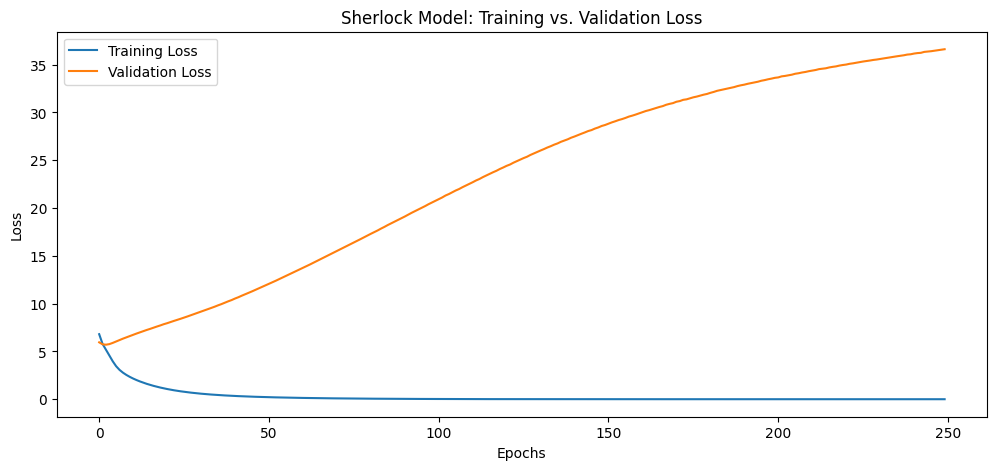

Final Validation Loss (Sherlock): 36.6082
Final Validation Accuracy (Sherlock): 6.56%


In [7]:
# 1. Plot Training vs Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history_sherlock.history['loss'], label='Training Loss')
plt.plot(history_sherlock.history['val_loss'], label='Validation Loss')
plt.title('Sherlock Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Report Final Validation Loss/Accuracy
final_val_loss = history_sherlock.history['val_loss'][-1]
final_val_acc = history_sherlock.history['val_accuracy'][-1]
print(f"Final Validation Loss (Sherlock): {final_val_loss:.4f}")
print(f"Final Validation Accuracy (Sherlock): {final_val_acc * 100:.2f}%")

Example Predictions

In [8]:
def generate_text_sherlock(seed_text, num_words_to_gen):
    generated_text = seed_text.lower()
    seed_tokens = generated_text.split()

    for _ in range(num_words_to_gen):
        # Prepare input: get last CONTEXT_LENGTH tokens
        context_tokens = seed_tokens[-CONTEXT_LENGTH_SHERLOCK:]

        # Pad if the seed is too short
        if len(context_tokens) < CONTEXT_LENGTH_SHERLOCK:
            pad_list = ['.'] * (CONTEXT_LENGTH_SHERLOCK - len(context_tokens))
            context_tokens = pad_list + context_tokens

        # Convert to integers, handling OOV words
        context_ints = []
        for word in context_tokens:
            if word in word_to_int_sherlock:
                context_ints.append(word_to_int_sherlock[word])
            else:
                context_ints.append(word_to_int_sherlock['<UNK>'])

        # Predict
        X_input = np.array([context_ints])
        y_pred_probs = model_sherlock.predict(X_input, verbose=0)

        # Get the word with the highest probability
        y_pred_int = np.argmax(y_pred_probs)

        # Convert back to word
        y_pred_word = int_to_word_sherlock[y_pred_int]

        # Append to output and update the seed
        generated_text += " " + y_pred_word
        seed_tokens.append(y_pred_word)

    return generated_text

# Generate examples
print("\n--- Generation Examples (Sherlock) ---")
print(f"SEED: 'holmes was a man of'\n{generate_text_sherlock('holmes was a man of', 50)}\n")
print(f"SEED: 'the crime was committed at'\n{generate_text_sherlock('the crime was committed at', 50)}\n")
print(f"SEED: 'i saw him on the'\n{generate_text_sherlock('i saw him on the', 50)}\n")


--- Generation Examples (Sherlock) ---
SEED: 'holmes was a man of'
holmes was a man of who is was an hours i can hardly him with his case . there is no doubt that you have detected and defeated in the mostcomplete manner one of the most determined attempts at bank robberythat have ever come within my experience . i have had one or two little

SEED: 'the crime was committed at'
the crime was committed at this we must really here is made . i larger i think of <UNK> but this way now you can it yourbag . in case we <UNK> must have been put out of my way to you thisprecaution <UNK> of their <UNK> time while i take a glance as to

SEED: 'i saw him on the'
i saw him on the pavement opposite there as a <UNK> <UNK> . if you remember out was it we have no doubt yet . but is you can found her hands . i held it out by the way when he <UNK> to open the door . why private bar chance <UNK> lestrade .



 Embedding Visualization

Embedding weights shape: (10000, 64)


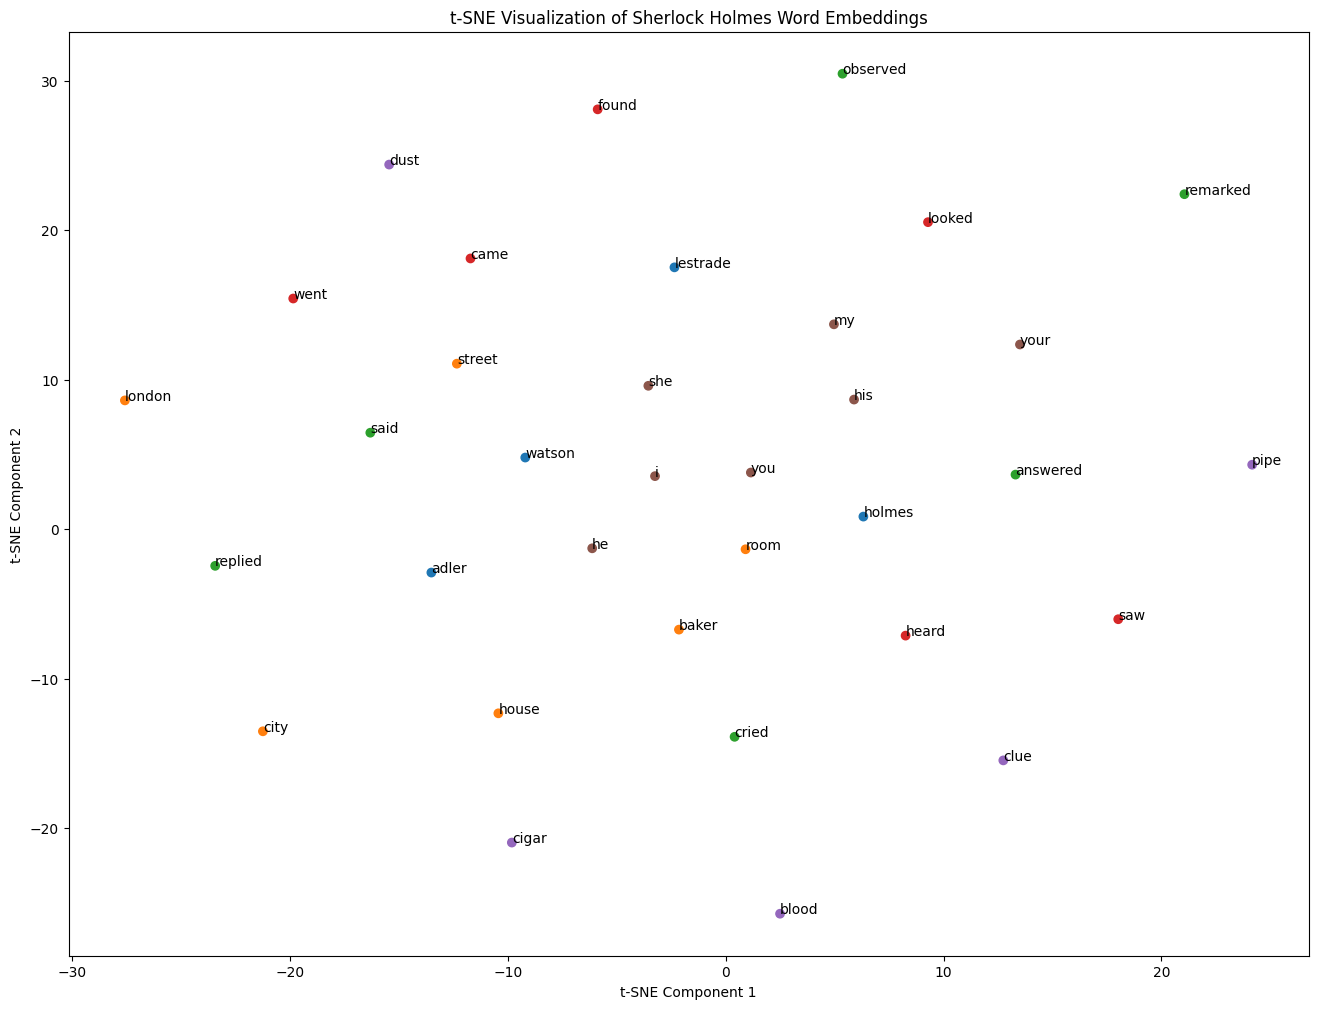

In [9]:
# Get the embedding layer weights
embedding_weights = model_sherlock.layers[0].get_weights()[0]
print(f"Embedding weights shape: {embedding_weights.shape}") # (VOCAB_SIZE, EMBED_DIM)

# Select specific words for visualization, as requested
words_to_visualize = {
    'names': ['holmes', 'watson', 'adler', 'moriarty', 'lestrade'],
    'locations': ['london', 'baker', 'street', 'room', 'house', 'city'],
    'speech_verbs': ['said', 'observed', 'remarked', 'answered', 'cried', 'replied'],
    'action_verbs': ['saw', 'looked', 'heard', 'found', 'came', 'went'],
    'evidence': ['pipe', 'cigar', 'dust', 'blood', 'footprint', 'clue'],
    'pronouns': ['i', 'he', 'she', 'you', 'his', 'my', 'your']
}

# Get the embedding vectors for these specific words
word_vectors = []
labels = []
colors = []
color_map = plt.get_cmap('tab10')

for i, (group_name, word_list) in enumerate(words_to_visualize.items()):
    for word in word_list:
        if word in word_to_int_sherlock:
            word_vectors.append(embedding_weights[word_to_int_sherlock[word]])
            labels.append(word)
            colors.append(color_map(i))

word_vectors = np.array(word_vectors)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_results = tsne.fit_transform(word_vectors)

# Plot the results
plt.figure(figsize=(16, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)

# Add annotations
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]))

plt.title('t-SNE Visualization of Sherlock Holmes Word Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [10]:
print("Observation: The t-SNE plot shows strong clustering for pronoun group, and speech/action verbs are distributed near narrative character names. Evidence-related terms are closer to location words, indicating context-dependent semantic similarity in the MLP embeddings.")


Observation: The t-SNE plot shows strong clustering for pronoun group, and speech/action verbs are distributed near narrative character names. Evidence-related terms are closer to location words, indicating context-dependent semantic similarity in the MLP embeddings.


Save Artifacts for Streamlit App

In [11]:
model_sherlock.save('sherlock_model.h5')

# Save the tokenizer (the word_to_int map)
sherlock_artifacts = {
    'word_to_int': word_to_int_sherlock,
    'int_to_word': int_to_word_sherlock,
    'context_length': CONTEXT_LENGTH_SHERLOCK
}
with open('sherlock_artifacts.pkl', 'wb') as f:
    pickle.dump(sherlock_artifacts, f)

print("Saved sherlock_model.h5 and sherlock_artifacts.pkl")


Saved sherlock_model.h5 and sherlock_artifacts.pkl
